FUZZY 1

In [9]:
import pandas as pd
import numpy as np
import random
import operator
import math
from sklearn.feature_extraction.text import TfidfVectorizer

# Reading the input dataset
df_full = pd.read_csv("balanced_dataset.csv")

# Extracting features
columns = list(df_full.columns)
features = columns[:-1]  # All columns except 'target'
class_labels = list(df_full['target'])  # Fake or Genuine
df = df_full[features]

# Convert text reviews to numerical vectors using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)  # Limit to top 500 features
X_text = vectorizer.fit_transform(df['text']).toarray()

# Combine text features with numerical ones (stars, useful, funny)
df_numeric = df[['stars', 'useful', 'funny']].values
df_combined = np.hstack((X_text, df_numeric))

# Update number of data points and attributes
num_attr = df_combined.shape[1]
n = df_combined.shape[0]

# Number of clusters and Fuzzy parameter
k = 2
m = 2.0
MAX_ITER = 100


In [10]:
def accuracy(cluster_labels, class_labels):
    tp = [0, 0]
    tn = [0, 0]
    fp = [0, 0]
    fn = [0, 0]
    
    # Mapping "fake" to 0 and "genuine" to 1
    for i in range(len(df)):
        # Cluster 0 -> Fake, Cluster 1 -> Genuine
        if cluster_labels[i] == 0 and class_labels[i] == 'fake':
            tp[0] += 1
        if cluster_labels[i] == 1 and class_labels[i] == 'genuine':
            tn[0] += 1
        if cluster_labels[i] == 0 and class_labels[i] == 'genuine':
            fp[0] += 1
        if cluster_labels[i] == 1 and class_labels[i] == 'fake':
            fn[0] += 1
        
        # Inverting the clusters to account for different possibilities
        if cluster_labels[i] == 1 and class_labels[i] == 'fake':
            tp[1] += 1
        if cluster_labels[i] == 0 and class_labels[i] == 'genuine':
            tn[1] += 1
        if cluster_labels[i] == 1 and class_labels[i] == 'genuine':
            fp[1] += 1
        if cluster_labels[i] == 0 and class_labels[i] == 'fake':
            fn[1] += 1
    
    a0 = (tp[0] + tn[0]) / (tp[0] + tn[0] + fn[0] + fp[0])
    a1 = (tp[1] + tn[1]) / (tp[1] + tn[1] + fn[1] + fp[1])
    p0 = tp[0] / (tp[0] + fp[0])
    p1 = tp[1] / (tp[1] + fp[1])
    r0 = tp[0] / (tp[0] + fn[0])
    r1 = tp[1] / (tp[1] + fn[1])
    
    accuracy = [a0 * 100, a1 * 100]
    precision = [p0 * 100, p1 * 100]
    recall = [r0 * 100, r1 * 100]
    
    return accuracy, precision, recall


In [11]:
def initializeMembershipMatrix():
    membership_mat = []
    for i in range(n):
        random_nums = [random.random() for _ in range(k)]
        summation = sum(random_nums)
        temp_list = [x/summation for x in random_nums]
        membership_mat.append(temp_list)
    return membership_mat


In [12]:
def calculateClusterCenter(membership_mat):
    cluster_mem_val = list(zip(*membership_mat))  # Convert zip to list
    cluster_centers = []
    for j in range(k):
        x = list(cluster_mem_val[j])
        xraised = [e ** m for e in x]
        denominator = sum(xraised)
        temp_num = []
        for i in range(n):
            data_point = df_combined[i]
            prod = [xraised[i] * val for val in data_point]
            temp_num.append(prod)
        numerator = map(sum, zip(*temp_num))
        center = [z / denominator for z in numerator]
        cluster_centers.append(center)
    return cluster_centers


In [13]:
def updateMembershipValue(membership_mat, cluster_centers):
    p = float(2 / (m - 1))
    for i in range(n):
        x = df_combined[i]
        distances = [np.linalg.norm(list(map(operator.sub, x, cluster_centers[j]))) for j in range(k)]
        for j in range(k):
            den = sum([math.pow(float(distances[j]/distances[c]), p) for c in range(k)])
            membership_mat[i][j] = float(1 / den)
    return membership_mat


In [14]:
def fuzzyCMeansClustering():
    membership_mat = initializeMembershipMatrix()
    curr = 0
    while curr <= MAX_ITER:
        cluster_centers = calculateClusterCenter(membership_mat)
        membership_mat = updateMembershipValue(membership_mat, cluster_centers)
        cluster_labels = getClusters(membership_mat)
        curr += 1
    return cluster_labels, cluster_centers


In [15]:
def getClusters(membership_mat):
    cluster_labels = []
    for i in range(n):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(membership_mat[i]))
        cluster_labels.append(idx)
    return cluster_labels


In [16]:
labels, centers = fuzzyCMeansClustering()

# Print cluster centers
print("Cluster Centers:", centers)

# Evaluate accuracy
a, p, r = accuracy(labels, class_labels)
print(f"Accuracy: {a}")
print(f"Precision: {p}")
print(f"Recall: {r}")


Cluster Centers: [[0.009365439691531625, 0.003517446762079141, 0.005405418184697359, 0.006119530071535375, 0.006034246808070287, 0.005016838845897213, 0.006007228612151854, 0.005206469787121787, 0.009445093025097913, 0.004067232971696112, 0.005110299191383402, 0.013432210058172288, 0.0046885323816468925, 0.016288651486366015, 0.0044160377089238895, 0.006703903252992848, 0.008173469301189451, 0.005142663663996918, 0.011021311210432037, 0.005067434610665444, 0.004035467074588393, 0.008016349808255436, 0.009083039389964496, 0.01172194562643956, 0.005745562534551379, 0.015287373679503688, 0.02248957026623938, 0.0045637935450727855, 0.00377997935461962, 0.006142944314821672, 0.005100808927935834, 0.005303647735744558, 0.007383928362944866, 0.01610914518539961, 0.006048227842365632, 0.00408681916352764, 0.02121975664068691, 0.019672405310614982, 0.012570748741438936, 0.016283263495739782, 0.004433292009787591, 0.004354595896797374, 0.0058208205535694325, 0.0046337929397956895, 0.009947582432

FUZZY 2

FUZZY 3

In [1]:
from sklearn.metrics import classification_report

def main():
    # Load and preprocess data
    df = pd.read_csv('balanced_dataset.csv')
    features = ['stars', 'useful', 'funny']  # Use relevant numerical features
    X = df[features].values
    y = df['target'].map({'genuine': 1, 'fake': 0}).values

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Fuzzy C-means clustering
    fcm = FuzzyCMeans(n_clusters=2, m=2.0, max_iter=100, epsilon=0.01)
    fcm.fit(X)
    y_pred = fcm.predict()

    # Evaluate
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

    # Classification report
    report = classification_report(y, y_pred, target_names=['fake', 'genuine'])
    print('\nClassification Report:\n', report)

if __name__ == '__main__':
    main()


C:\Users\Shiva\AppData\Local\Temp\ipykernel_4848\2659696080.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.u[i, j] = 1 / np.sum(


Accuracy: 0.937559704732957
Precision: 0.9914171462011119
Recall: 0.8827616152844117


FUZZY 4

In [7]:
from sklearn.metrics import classification_report

def main():
    # Load and preprocess data
    df = pd.read_csv('balanced_dataset.csv')
    features = ['stars', 'useful', 'funny']  # Use relevant numerical features
    X = df[features].values
    y = df['target'].map({'genuine': 1, 'fake': 0}).values

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Fuzzy C-means clustering
    fcm = FuzzyCMeans(n_clusters=2, m=2.0, max_iter=100, epsilon=0.01)
    fcm.fit(X)
    y_pred = fcm.predict()

    # Evaluate
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

    # Classification report
    report = classification_report(y, y_pred, target_names=['fake', 'genuine'])
    print('\nClassification Report:\n', report)

if __name__ == '__main__':
    main()


C:\Users\Shiva\AppData\Local\Temp\ipykernel_4848\2016099517.py:39: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.u[i, j] = 1 / np.sum(


Accuracy: 0.937559704732957
Precision: 0.9914171462011119
Recall: 0.8827616152844117

Classification Report:
               precision    recall  f1-score   support

        fake       0.89      0.99      0.94     11515
     genuine       0.99      0.88      0.93     11515

    accuracy                           0.94     23030
   macro avg       0.94      0.94      0.94     23030
weighted avg       0.94      0.94      0.94     23030



In [14]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

class FuzzyCMeans:
    def __init__(self, n_clusters=2, m=2.0, max_iter=100, epsilon=0.01):
        self.n_clusters = n_clusters
        self.m = m
        self.max_iter = max_iter
        self.epsilon = epsilon

    def fit(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape
        self.u = np.random.rand(self.n_samples, self.n_clusters)
        self.u = self.u / np.sum(self.u, axis=1, keepdims=True)

        for _ in range(self.max_iter):
            self.centers = self._calculate_centers()
            u_prev = self.u.copy()
            self._update_membership()
            if np.linalg.norm(self.u - u_prev) < self.epsilon:
                break

    def _calculate_centers(self):
        centers = np.zeros((self.n_clusters, self.n_features))
        for j in range(self.n_clusters):
            num = np.sum((self.u[:, j] ** self.m)[:, np.newaxis] * self.X, axis=0)
            denom = np.sum(self.u[:, j] ** self.m)
            centers[j] = num / denom
        return centers

    def _update_membership(self):
        for i in range(self.n_samples):
            for j in range(self.n_clusters):
                dist = np.linalg.norm(self.X[i] - self.centers[j])
                self.u[i, j] = 1 / np.sum(
                    (dist / np.linalg.norm(self.X[i] - self.centers[k])) ** (2 / (self.m - 1))
                    for k in range(self.n_clusters)
                )

    def predict(self):
        return np.argmax(self.u, axis=1)

def evaluate_model(X, y, n_runs=10):
    accuracy_list = []
    precision_list = []
    recall_list = []
    reports = []

    for _ in range(n_runs):
        fcm = FuzzyCMeans(n_clusters=2, m=2.0, max_iter=100, epsilon=0.01)
        fcm.fit(X)
        y_pred = fcm.predict()

        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)

        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)

        report = classification_report(y, y_pred, target_names=['fake', 'genuine'], zero_division=0)
        reports.append(report)

    return np.mean(accuracy_list), np.mean(precision_list), np.mean(recall_list), reports

def main():
    # Load and preprocess data
    df = pd.read_csv('balanced_dataset.csv')
    
    # Focus on the text feature only
    X = df['text']
    y = df['target'].map({'genuine': 1, 'fake': 0}).values

    # Convert text to TF-IDF features with n-grams
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.9, min_df=5)
    X_tfidf = vectorizer.fit_transform(X)  # Keep sparse matrix

    # Apply TruncatedSVD to reduce dimensionality (works directly on sparse data)
    svd = TruncatedSVD(n_components=100)  # You can try changing n_components
    X_reduced = svd.fit_transform(X_tfidf)

    # Evaluate model
    mean_accuracy, mean_precision, mean_recall, reports = evaluate_model(X_reduced, y, n_runs=10)

    print(f'Mean Accuracy: {mean_accuracy:.4f}')
    print(f'Mean Precision: {mean_precision:.4f}')
    print(f'Mean Recall: {mean_recall:.4f}')

    # Print the classification report from the last run
    print("Classification Report (last run):")
    print(reports[-1])

if __name__ == '__main__':
    main()


C:\Users\Shiva\AppData\Local\Temp\ipykernel_4848\1261665101.py:39: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.u[i, j] = 1 / np.sum(
C:\Users\Shiva\AppData\Local\Temp\ipykernel_4848\1261665101.py:39: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.u[i, j] = 1 / np.sum(
C:\Users\Shiva\AppData\Local\Temp\ipykernel_4848\1261665101.py:39: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.u[i, j] = 1 / np.sum(
C:\Users\Shiva\AppData\Local\Temp\ipykernel_4848\1261665101.py:39: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result.

Mean Accuracy: 0.5026
Mean Precision: 0.5014
Mean Recall: 0.5176
Classification Report (last run):
              precision    recall  f1-score   support

        fake       0.55      0.52      0.53     11515
     genuine       0.54      0.58      0.56     11515

    accuracy                           0.55     23030
   macro avg       0.55      0.55      0.55     23030
weighted avg       0.55      0.55      0.55     23030



In [15]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

class FuzzyCMeans:
    def __init__(self, n_clusters=2, m=2.0, max_iter=150, epsilon=0.01):
        self.n_clusters = n_clusters
        self.m = m
        self.max_iter = max_iter
        self.epsilon = epsilon

    def fit(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape
        self.u = np.random.rand(self.n_samples, self.n_clusters)
        self.u = self.u / np.sum(self.u, axis=1, keepdims=True)

        for _ in range(self.max_iter):
            self.centers = self._calculate_centers()
            u_prev = self.u.copy()
            self._update_membership()
            if np.linalg.norm(self.u - u_prev) < self.epsilon:
                break

    def _calculate_centers(self):
        centers = np.zeros((self.n_clusters, self.n_features))
        for j in range(self.n_clusters):
            num = np.sum((self.u[:, j] ** self.m)[:, np.newaxis] * self.X, axis=0)
            denom = np.sum(self.u[:, j] ** self.m)
            centers[j] = num / denom
        return centers

    def _update_membership(self):
        for i in range(self.n_samples):
            for j in range(self.n_clusters):
                dist = np.linalg.norm(self.X[i] - self.centers[j])
                self.u[i, j] = 1 / np.sum(
                    (dist / np.linalg.norm(self.X[i] - self.centers[k])) ** (2 / (self.m - 1))
                    for k in range(self.n_clusters)
                )

    def predict(self, threshold=0.5):
        # Apply a membership threshold to assign labels
        predictions = np.where(self.u[:, 1] > threshold, 1, 0)
        return predictions

def evaluate_model(X, y, n_runs=10, m_values=[1.5, 2.0], thresholds=[0.4, 0.5, 0.6]):
    best_accuracy = 0
    best_precision = 0
    best_recall = 0
    best_report = None
    best_m = None
    best_threshold = None

    for m in m_values:
        for threshold in thresholds:
            accuracy_list = []
            precision_list = []
            recall_list = []
            reports = []

            for _ in range(n_runs):
                fcm = FuzzyCMeans(n_clusters=2, m=m, max_iter=150, epsilon=0.01)
                fcm.fit(X)
                y_pred = fcm.predict(threshold=threshold)

                accuracy = accuracy_score(y, y_pred)
                precision = precision_score(y, y_pred, zero_division=0)
                recall = recall_score(y, y_pred, zero_division=0)

                accuracy_list.append(accuracy)
                precision_list.append(precision)
                recall_list.append(recall)

                report = classification_report(y, y_pred, target_names=['fake', 'genuine'], zero_division=0)
                reports.append(report)

            mean_accuracy = np.mean(accuracy_list)
            mean_precision = np.mean(precision_list)
            mean_recall = np.mean(recall_list)

            if mean_accuracy > best_accuracy:
                best_accuracy = mean_accuracy
                best_precision = mean_precision
                best_recall = mean_recall
                best_report = reports[-1]
                best_m = m
                best_threshold = threshold

    return best_accuracy, best_precision, best_recall, best_report, best_m, best_threshold

def main():
    # Load and preprocess data
    df = pd.read_csv('balanced_dataset.csv')
    
    # Focus on the text feature only
    X = df['text']
    y = df['target'].map({'genuine': 1, 'fake': 0}).values

    # Convert text to TF-IDF features with n-grams
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.85, min_df=5)
    X_tfidf = vectorizer.fit_transform(X)  # Keep sparse matrix

    # Apply more aggressive TruncatedSVD to reduce dimensionality
    svd = TruncatedSVD(n_components=25)  # Reduced further
    X_reduced = svd.fit_transform(X_tfidf)

    # Perform hyperparameter tuning for m and threshold
    best_accuracy, best_precision, best_recall, best_report, best_m, best_threshold = evaluate_model(
        X_reduced, y, n_runs=5, m_values=[1.5, 2.0, 2.5], thresholds=[0.3, 0.4, 0.5]
    )

    print(f'Best Mean Accuracy: {best_accuracy:.4f}')
    print(f'Best Mean Precision: {best_precision:.4f}')
    print(f'Best Mean Recall: {best_recall:.4f}')
    print(f'Best m: {best_m}')
    print(f'Best Threshold: {best_threshold}')

    # Print the classification report from the best run
    print("Best Classification Report:")
    print(best_report)

if __name__ == '__main__':
    main()


C:\Users\Shiva\AppData\Local\Temp\ipykernel_4848\3042425601.py:39: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.u[i, j] = 1 / np.sum(
C:\Users\Shiva\AppData\Local\Temp\ipykernel_4848\3042425601.py:39: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.u[i, j] = 1 / np.sum(
C:\Users\Shiva\AppData\Local\Temp\ipykernel_4848\3042425601.py:39: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.u[i, j] = 1 / np.sum(
C:\Users\Shiva\AppData\Local\Temp\ipykernel_4848\3042425601.py:39: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result.

Best Mean Accuracy: 0.5210
Best Mean Precision: 0.5188
Best Mean Recall: 0.5446
Best m: 2.0
Best Threshold: 0.5
Best Classification Report:
              precision    recall  f1-score   support

        fake       0.53      0.51      0.52     11515
     genuine       0.53      0.55      0.54     11515

    accuracy                           0.53     23030
   macro avg       0.53      0.53      0.53     23030
weighted avg       0.53      0.53      0.53     23030



In [17]:
import optuna
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

class FuzzyCMeans:
    def __init__(self, n_clusters=2, m=2.0, max_iter=150, epsilon=0.01):
        self.n_clusters = n_clusters
        self.m = m
        self.max_iter = max_iter
        self.epsilon = epsilon

    def fit(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape
        self.u = np.random.rand(self.n_samples, self.n_clusters)
        self.u = self.u / np.sum(self.u, axis=1, keepdims=True)

        for _ in range(self.max_iter):
            self.centers = self._calculate_centers()
            u_prev = self.u.copy()
            self._update_membership()
            if np.linalg.norm(self.u - u_prev) < self.epsilon:
                break

    def _calculate_centers(self):
        centers = np.zeros((self.n_clusters, self.n_features))
        for j in range(self.n_clusters):
            num = np.sum((self.u[:, j] ** self.m)[:, np.newaxis] * self.X, axis=0)
            denom = np.sum(self.u[:, j] ** self.m)
            centers[j] = num / denom
        return centers

    def _update_membership(self):
        for i in range(self.n_samples):
            for j in range(self.n_clusters):
                dist = np.linalg.norm(self.X[i] - self.centers[j])
                self.u[i, j] = 1 / np.sum(
                    (dist / np.linalg.norm(self.X[i] - self.centers[k])) ** (2 / (self.m - 1))
                    for k in range(self.n_clusters)
                )

    def predict(self, threshold=0.5):
        predictions = np.where(self.u[:, 1] > threshold, 1, 0)
        return predictions

def objective(trial, X, y):
    # Suggest hyperparameters
    m = trial.suggest_float('m', 1.5, 2.5)  # Fuzziness parameter
    threshold = trial.suggest_float('threshold', 0.3, 0.7)  # Threshold for cluster assignment

    # Run Fuzzy C-Means clustering
    fcm = FuzzyCMeans(n_clusters=2, m=m, max_iter=150, epsilon=0.01)
    fcm.fit(X)
    y_pred = fcm.predict(threshold=threshold)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred, zero_division=0)

    # Return metric to optimize (maximize accuracy)
    return accuracy

def main():
    # Load and preprocess data
    df = pd.read_csv('balanced_dataset.csv')

    # Focus on the text feature only
    X = df['text']
    y = df['target'].map({'genuine': 1, 'fake': 0}).values

    # Convert text to TF-IDF features with n-grams
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.85, min_df=5)
    X_tfidf = vectorizer.fit_transform(X)  # Keep sparse matrix

    # Apply TruncatedSVD to reduce dimensionality
    svd = TruncatedSVD(n_components=25)
    X_reduced = svd.fit_transform(X_tfidf)

    # Perform hyperparameter tuning using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X_reduced, y), n_trials=50)

    # Get the best hyperparameters
    best_trial = study.best_trial
    print(f'Best Hyperparameters: m={best_trial.params["m"]}, threshold={best_trial.params["threshold"]}')
    print(f'Best Accuracy: {best_trial.value:.4f}')

    # Run the model with the best hyperparameters
    fcm = FuzzyCMeans(n_clusters=2, m=best_trial.params["m"], max_iter=150, epsilon=0.01)
    fcm.fit(X_reduced)
    y_pred = fcm.predict(threshold=best_trial.params["threshold"])

    # Output the classification report
    print("Classification Report (best run):")
    print(classification_report(y, y_pred, target_names=['fake', 'genuine'], zero_division=0))

if __name__ == '__main__':
    main()


[I 2024-10-02 22:24:38,165] A new study created in memory with name: no-name-c3c68969-bf99-4bfe-b948-f03767d5b95b
C:\Users\Shiva\AppData\Local\Temp\ipykernel_4848\506966814.py:40: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.u[i, j] = 1 / np.sum(
[I 2024-10-02 22:24:41,580] Trial 0 finished with value: 0.5 and parameters: {'m': 2.31686381382174, 'threshold': 0.32020374100490484}. Best is trial 0 with value: 0.5.
C:\Users\Shiva\AppData\Local\Temp\ipykernel_4848\506966814.py:40: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.u[i, j] = 1 / np.sum(
[I 2024-10-02 22:24:45,665] Trial 1 finished with value: 0.5 and parameters: {'m': 2.0336905653433783, 'threshold': 0.31883972810900374}. Best is trial 0 with value: 0.5

Best Hyperparameters: m=2.31686381382174, threshold=0.32020374100490484
Best Accuracy: 0.5000
Classification Report (best run):
              precision    recall  f1-score   support

        fake       0.00      0.00      0.00     11515
     genuine       0.50      1.00      0.67     11515

    accuracy                           0.50     23030
   macro avg       0.25      0.50      0.33     23030
weighted avg       0.25      0.50      0.33     23030



In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from fcmeans import FCM
import optuna

# Function to apply FCM and return accuracy, precision, recall
def evaluate_fcm(X, y, m, threshold, n_clusters=2, n_init=10):
    best_accuracy = 0
    best_fcm = None
    best_labels = None

    for _ in range(n_init):  # Repeat with different initializations
        fcm = FCM(n_clusters=n_clusters, m=m)
        fcm.fit(X)
        membership = fcm.u.T
        
        # Post-process membership values with rule-based approach
        predicted_labels = np.argmax(membership, axis=0)
        memberships_diff = np.abs(membership[0] - membership[1])
        predicted_labels = np.where(memberships_diff > threshold, predicted_labels, 1 - predicted_labels)
        
        # Evaluate performance
        accuracy = accuracy_score(y, predicted_labels)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_fcm = fcm
            best_labels = predicted_labels

    return best_accuracy, best_fcm, best_labels

# Objective function for Optuna
def objective(trial):
    # Sample hyperparameters for fuzziness and threshold
    m = trial.suggest_float('m', 1.5, 3.0)
    threshold = trial.suggest_float('threshold', 0.2, 0.8)
    
    # Evaluate FCM with sampled hyperparameters
    accuracy, _, _ = evaluate_fcm(X_tfidf_pca, y, m, threshold)
    return 1.0 - accuracy  # Minimize 1 - accuracy

# Main function
def main():
    # Load your dataset (adjust path as necessary)
    df = pd.read_csv('balanced_dataset.csv')
    X = df['text'].values
    y = np.where(df['target'] == 'fake', 0, 1)  # Convert labels to binary

    # Convert text to TF-IDF features with n-grams
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.9, min_df=5)
    X_tfidf = vectorizer.fit_transform(X)

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=50)  # Try reducing to 50 dimensions
    X_tfidf_pca = pca.fit_transform(X_tfidf.toarray())

    # Split data for evaluation (using the whole dataset here, but you can use train-test split)
    
    # Optuna hyperparameter optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)  # Try with 50 trials
    
    # Best hyperparameters
    best_m = study.best_params['m']
    best_threshold = study.best_params['threshold']
    print(f"Best Hyperparameters: m={best_m}, threshold={best_threshold}")
    
    # Evaluate FCM with best hyperparameters
    best_accuracy, best_fcm, best_labels = evaluate_fcm(X_tfidf_pca, y, best_m, best_threshold)
    
    print(f"Best Accuracy: {best_accuracy:.4f}")
    
    # Generate classification report
    print("Classification Report:")
    print(classification_report(y, best_labels, target_names=['fake', 'genuine']))

if __name__ == '__main__':
    main()


MemoryError: Unable to allocate 8.18 GiB for an array with shape (23030, 47685) and data type float64

In [5]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

def preprocess_data(file_path):
    # Load dataset
    df = pd.read_csv(file_path)
    
    # Extract relevant columns
    df = df[['text', 'target']]
    
    # Convert text data to numerical features using TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(df['text'])
    
    # Apply dimensionality reduction
    svd = TruncatedSVD(n_components=100)  # Reduce to 100 dimensions
    X = svd.fit_transform(X)
    
    # Encode target labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['target'])
    
    return X, y

def fuzzy_c_means(X, k, m=2.0, max_iter=100, epsilon=0.01):
    n_samples, n_features = X.shape
    u = np.random.rand(n_samples, k)
    u = u / np.sum(u, axis=1, keepdims=True)  # Normalize membership matrix

    for _ in range(max_iter):
        u_prev = u.copy()
        cluster_centers = np.dot(u.T ** m, X) / np.sum(u.T ** m, axis=1, keepdims=True)

        distances = np.linalg.norm(X[:, np.newaxis] - cluster_centers, axis=2)
        u = 1.0 / np.sum((distances[:, :, np.newaxis] / distances[:, np.newaxis]) ** (2 / (m - 1)), axis=2)

        # Check convergence
        if np.linalg.norm(u - u_prev) < epsilon:
            break

    labels = np.argmax(u, axis=1)
    return labels, cluster_centers

def evaluate_clustering(labels, y):
    accuracy = accuracy_score(y, labels)
    precision = precision_score(y, labels, average='weighted')
    recall = recall_score(y, labels, average='weighted')
    return accuracy, precision, recall

# File path to the dataset
file_path = 'balanced_dataset.csv'

# Preprocess data
X, y = preprocess_data(file_path)

# Perform Fuzzy C-means clustering
labels, centers = fuzzy_c_means(X, k=2, m=2.0, max_iter=100, epsilon=0.01)

# Print cluster centers
print("Cluster Centers:")
print(centers)

# Evaluate clustering
accuracy, precision, recall = evaluate_clustering(labels, y)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Confusion matrix
conf_matrix = confusion_matrix(y, labels)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(y, labels)
print("Classification Report:")
print(class_report)


Cluster Centers:
[[ 1.41249225e-01 -6.48040323e-03  1.32928309e-03 -1.02808579e-03
   1.48203406e-03 -2.32888986e-03 -2.47557687e-03 -7.24679766e-04
   1.62497116e-03 -5.67599033e-04 -1.60320204e-03  9.46230889e-04
   8.66565799e-04  1.28122511e-03  3.06109327e-04  9.65973806e-04
  -2.05333166e-04  9.20409479e-04  1.47464697e-03 -1.03631372e-03
  -3.28369969e-04 -9.65071675e-05  5.90302539e-04  1.65437258e-04
   2.88683909e-04  8.18172998e-05  6.80605209e-04 -1.00075414e-03
  -4.20520627e-04 -5.80258822e-04  9.97854158e-04  1.09460433e-04
   9.40761964e-04 -2.30986410e-04  2.97478821e-04  6.68998484e-04
  -7.61014832e-05 -4.13496168e-04  7.99675116e-04 -6.07181054e-04
  -6.70839258e-05 -8.94304603e-05  5.73961689e-04  5.95883050e-04
  -8.41201284e-04  1.25878357e-04  1.30785632e-04  2.11379467e-04
   5.23140604e-04 -3.99273065e-04  5.24185792e-04  8.91776102e-04
  -1.81064059e-04  1.34546930e-04  1.63387618e-05  3.41091548e-04
  -6.22517192e-04 -3.10770338e-04 -2.93766798e-04 -1.864172

In [ ]:
FUZZY 5

In [8]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from scipy.sparse import csr_matrix

def preprocess_data(file_path):
    # Load dataset
    df = pd.read_csv(file_path)
    
    # Extract relevant columns
    df = df[['text', 'useful', 'funny', 'target']]
    
    # Convert text data to numerical features using sparse TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # Limit features to reduce dimensionality
    text_features = vectorizer.fit_transform(df['text'])
    
    # Extract and scale numeric features
    numeric_features = df[['useful', 'funny']].fillna(0)
    scaler = StandardScaler()
    numeric_features_scaled = scaler.fit_transform(numeric_features)
    
    # Dimensionality reduction for numeric features using PCA
    pca = PCA(n_components=2)  # Limit to 2 components
    numeric_features_reduced = pca.fit_transform(numeric_features_scaled)
    
    # Combine sparse text features with reduced numeric features
    X = csr_matrix(np.hstack([text_features.toarray(), numeric_features_reduced]))  # Combine sparse and dense arrays
    
    # Encode target labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['target'])
    
    return X, y

def fuzzy_c_means(X, k, m=2.0, max_iter=100, epsilon=0.01, batch_size=5000):
    n_samples, n_features = X.shape
    u = np.random.rand(n_samples, k)
    u = u / np.sum(u, axis=1, keepdims=True)  # Normalize membership matrix

    for iteration in range(max_iter):
        u_prev = u.copy()
        
        # Batch processing
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            X_batch = X[start:end]
            u_batch = u[start:end]
            
            # Compute cluster centers
            u_m = u_batch ** m
            cluster_centers = np.dot(u_m.T, X_batch.toarray()) / np.sum(u_m, axis=0, keepdims=True).T
            
            # Compute distances
            distances = np.linalg.norm(X_batch.toarray()[:, np.newaxis] - cluster_centers, axis=2)
            u[start:end] = 1.0 / np.sum((distances[:, :, np.newaxis] / distances[:, np.newaxis]) ** (2 / (m - 1)), axis=2)
        
        # Check convergence
        if np.linalg.norm(u - u_prev) < epsilon:
            break

    labels = np.argmax(u, axis=1)
    return labels, cluster_centers

def evaluate_clustering(labels, y):
    accuracy = accuracy_score(y, labels)
    precision = precision_score(y, labels, average='weighted')
    recall = recall_score(y, labels, average='weighted')
    return accuracy, precision, recall

# File path to the dataset
file_path = 'balanced_dataset.csv'

# Preprocess data
X, y = preprocess_data(file_path)

# Perform Fuzzy C-means clustering
labels, centers = fuzzy_c_means(X, k=2, m=2.0, max_iter=100, epsilon=0.01)

# Print cluster centers
print("Cluster Centers:")
print(centers)

# Evaluate clustering
accuracy, precision, recall = evaluate_clustering(labels, y)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Confusion matrix
conf_matrix = confusion_matrix(y, labels)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(y, labels)
print("Classification Report:")
print(class_report)


Cluster Centers:
[[ 0.00190953  0.00017815  0.0005267  ...  0.00056102 -0.06908985
  -0.05793134]
 [ 0.00190953  0.00017815  0.0005267  ...  0.00056102 -0.06908985
  -0.05793134]]
Accuracy: 0.4742075553625706
Precision: 0.473218383556886
Recall: 0.4742075553625706
Confusion Matrix:
[[6567 4948]
 [7161 4354]]
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.57      0.52     11515
           1       0.47      0.38      0.42     11515

    accuracy                           0.47     23030
   macro avg       0.47      0.47      0.47     23030
weighted avg       0.47      0.47      0.47     23030



In [4]:
pip install -U scikit-fuzzy


   ---------------------------------------- 0.0/920.8 kB ? eta -:--:--
    -------------------------------------- 20.5/920.8 kB 330.3 kB/s eta 0:00:03
   - ------------------------------------- 30.7/920.8 kB 217.9 kB/s eta 0:00:05
   - ------------------------------------- 41.0/920.8 kB 326.8 kB/s eta 0:00:03
   - ------------------------------------- 41.0/920.8 kB 326.8 kB/s eta 0:00:03
   ------ ------------------------------- 153.6/920.8 kB 612.6 kB/s eta 0:00:02
   ----------- -------------------------- 286.7/920.8 kB 983.9 kB/s eta 0:00:01
   ------------------------------------- -- 870.4/920.8 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 920.8/920.8 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-fuzzy
    Found existing installation: scikit-fuzzy 0.4.2
    Uninstalling scikit-fuzzy-0.4.2:
      Successfully uninstalled scikit-fuzzy-0.4.2
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from skfuzzy.cluster import cmeans
from scipy.sparse import csr_matrix
from imblearn.over_sampling import SMOTE

# Preprocess data
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    # Select relevant features
    df = df[['text', 'useful', 'funny', 'target']]
    
    # Split data into text and numeric features
    text_data = df['text']
    numeric_features = df[['useful', 'funny']]

    # Text vectorization using TF-IDF
    vectorizer = TfidfVectorizer(max_features=10000)
    text_features = vectorizer.fit_transform(text_data)
    
    # Dimensionality reduction for text features using PCA
    pca = PCA(n_components=50)
    text_features_reduced = pca.fit_transform(text_features.toarray())

    # Standardize numeric features
    scaler = StandardScaler()
    numeric_features_scaled = scaler.fit_transform(numeric_features)
    
    # Apply PCA on numeric features
    pca_numeric = PCA(n_components=2)
    numeric_features_reduced = pca_numeric.fit_transform(numeric_features_scaled)
    
    # Combine TF-IDF features with numeric features
    combined_features = np.hstack([text_features_reduced, numeric_features_reduced])
    
    # Get the target labels (convert 'fake'/'genuine' to 0/1)
    y = df['target'].apply(lambda x: 1 if x == 'genuine' else 0).values
    
    # Handle class imbalance
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(combined_features, y)
    
    return X_resampled, y_resampled

# Fuzzy C-means clustering
def fuzzy_c_means(X, k=2, m=2.0, max_iter=300, epsilon=1e-6):
    # Apply fuzzy c-means clustering
    cntr, u, u0, d, jm, p, fpc = cmeans(X.T, c=k, m=m, error=epsilon, maxiter=max_iter, init=None)
    
    # Predict cluster membership
    labels = np.argmax(u, axis=0)
    
    return labels, cntr

# Evaluation metrics
def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Accuracy: {acc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

# Main function
if __name__ == "__main__":
    # Path to your CSV file
    file_path = 'balanced_dataset.csv'
    
    # Load and preprocess data
    X, y = preprocess_data(file_path)
    
    # Perform Fuzzy C-means clustering with adjusted parameters
    labels, centers = fuzzy_c_means(X, k=2, m=2.0, max_iter=300, epsilon=1e-6)
    
    # Print cluster centers
    print("Cluster Centers:")
    print(centers)
    
    # Evaluate the clustering model
    evaluate_model(y, labels)


Cluster Centers:
[[ 3.70094091e-02  3.67136743e-02  1.62563398e-02  2.21671941e-03
  -1.36338976e-02 -9.15482290e-03  5.25985093e-03 -8.02427284e-03
   2.15671202e-04  2.09489596e-03 -4.31139607e-03 -2.89895003e-03
   4.32322056e-03 -1.61995379e-03 -8.74647473e-03  5.72593010e-04
   6.50987273e-04 -5.69423895e-04  1.87966422e-03 -3.52848393e-03
  -1.52310877e-03  8.15577359e-05 -1.53271485e-03  2.20915115e-03
  -8.71019151e-06  1.57115749e-03  1.20074316e-03  2.06878224e-04
   1.21566023e-03  3.18093838e-03 -1.28023245e-03 -3.21380705e-04
   1.18245054e-04 -2.86533548e-04  7.37629419e-04  8.13854227e-04
   5.14093428e-04 -2.60189124e-03 -1.16392241e-04 -1.00190302e-03
   1.68803122e-03  1.65985472e-04 -2.10803822e-03  2.30748885e-04
  -3.55984268e-04 -2.56217808e-03 -1.39399717e-04  1.58779635e-03
  -1.82401855e-03 -7.16958504e-04  1.99229546e+00 -4.88845694e-01]
 [-6.18166787e-03 -5.88566149e-03 -2.81660517e-03 -6.01311204e-04
   1.93759209e-03  1.30330587e-03 -8.87469132e-04  1.10652

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split

class FuzzyCMeans:
    def __init__(self, n_clusters=2, m=2.0, max_iter=100, epsilon=0.01):
        self.n_clusters = n_clusters
        self.m = m
        self.max_iter = max_iter
        self.epsilon = epsilon

    def fit(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape
        self.u = np.random.rand(self.n_samples, self.n_clusters)
        self.u = self.u / np.sum(self.u, axis=1, keepdims=True)

        for _ in range(self.max_iter):
            self.centers = self._calculate_centers()
            u_prev = self.u.copy()
            self._update_membership()
            if np.linalg.norm(self.u - u_prev) < self.epsilon:
                break

    def _calculate_centers(self):
        centers = np.zeros((self.n_clusters, self.n_features))
        for j in range(self.n_clusters):
            num = np.sum((self.u[:, j] ** self.m)[:, np.newaxis] * self.X, axis=0)
            denom = np.sum(self.u[:, j] ** self.m)
            centers[j] = num / denom
        return centers

    def _update_membership(self):
        for i in range(self.n_samples):
            for j in range(self.n_clusters):
                dist = np.linalg.norm(self.X[i] - self.centers[j])
                self.u[i, j] = 1 / sum(
                    (dist / np.linalg.norm(self.X[i] - self.centers[k])) ** (2 / (self.m - 1))
                    for k in range(self.n_clusters)
                )

    def predict(self):
        return np.argmax(self.u, axis=1)

def main():
    # Load and preprocess data
    df = pd.read_csv('balanced_dataset.csv')
    features = ['stars', 'useful', 'funny']  # Use relevant numerical features
    X = df[features].values
    y = df['target'].map({'genuine': 1, 'fake': 0}).values

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fuzzy C-means clustering
    fcm = FuzzyCMeans(n_clusters=2, m=2.0, max_iter=100, epsilon=0.01)
    fcm.fit(X_train)
    y_pred_train = fcm.predict()

    # Clustering evaluation metrics
    silhouette_avg = silhouette_score(X_train, y_pred_train)
    davies_bouldin_avg = davies_bouldin_score(X_train, y_pred_train)

    print(f'Training Silhouette Score: {silhouette_avg}')
    print(f'Training Davies-Bouldin Index: {davies_bouldin_avg}')

    # Predict on the test set
    fcm.fit(X_test)
    y_pred_test = fcm.predict()

    # Clustering evaluation metrics for test data
    silhouette_avg_test = silhouette_score(X_test, y_pred_test)
    davies_bouldin_avg_test = davies_bouldin_score(X_test, y_pred_test)

    print(f'Test Silhouette Score: {silhouette_avg_test}')
    print(f'Test Davies-Bouldin Index: {davies_bouldin_avg_test}')

if __name__ == '__main__':
    main()

Training Silhouette Score: 0.41281517565943665
Training Davies-Bouldin Index: 1.0537244105605363
Test Silhouette Score: 0.40909542112034936
Test Davies-Bouldin Index: 1.0778565120614865


In [9]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
df = pd.read_csv('balanced_dataset.csv')

# Text preprocessing: Convert the text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['text']).toarray()  # Convert text to numerical form
y = df['target'].map({'fake': 0, 'genuine': 1}).values  # Map labels to 0 and 1

# Dimensionality reduction with PCA (try reducing features to 50)
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

# Fuzzy C-Means clustering function
def fuzzy_c_means(X, n_clusters, m=2.0, error=0.005, maxiter=1000):
    n_samples, n_features = X.shape

    # Initialize fuzzy partition matrix randomly
    u = np.random.rand(n_samples, n_clusters)
    u = u / np.sum(u, axis=1, keepdims=True)

    # Run the clustering algorithm
    for i in range(maxiter):
        u_old = u.copy()

        # Calculate cluster centers
        centers = np.dot(u.T**m, X) / np.sum(u.T**m, axis=1, keepdims=True)

        # Update membership matrix
        distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
        distances = np.fmax(distances, np.finfo(np.float64).eps)

        u = 1 / distances**(2/(m-1))
        u = u / np.sum(u, axis=1, keepdims=True)

        # Check for convergence
        if np.linalg.norm(u - u_old) < error:
            break

    return centers, u

# Set number of clusters
n_clusters = 2

# Apply Fuzzy C-Means clustering on training data
centers, u_train = fuzzy_c_means(X_train, n_clusters)

# Use the membership values (soft assignments) from FCM as features
# Apply Fuzzy C-Means on test data
_, u_test = fuzzy_c_means(X_test, n_clusters)

# Concatenate FCM membership features with original features
X_train_augmented = np.hstack([X_train, u_train])
X_test_augmented = np.hstack([X_test, u_test])

# Train a Logistic Regression model using the augmented feature space
clf = LogisticRegression()
clf.fit(X_train_augmented, y_train)

# Predict on the test set
y_pred = clf.predict(X_test_augmented)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.7260095527572731
Precision: 0.7361405634656165
Recall: 0.7039397450753186
F1 Score: 0.7196801421590404


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

class FuzzyCMeans:
    def __init__(self, n_clusters=2, m=2.0, max_iter=100, epsilon=0.01):
        self.n_clusters = n_clusters
        self.m = m
        self.max_iter = max_iter
        self.epsilon = epsilon

    def fit(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape
        self.u = np.random.rand(self.n_samples, self.n_clusters)
        self.u = self.u / np.sum(self.u, axis=1, keepdims=True)

        for _ in range(self.max_iter):
            self.centers = self._calculate_centers()
            u_prev = self.u.copy()
            self._update_membership()
            if np.linalg.norm(self.u - u_prev) < self.epsilon:
                break

    def _calculate_centers(self):
        centers = np.zeros((self.n_clusters, self.n_features))
        for j in range(self.n_clusters):
            num = np.sum((self.u[:, j] ** self.m)[:, np.newaxis] * self.X, axis=0)
            denom = np.sum(self.u[:, j] ** self.m)
            centers[j] = num / denom
        return centers

    def _update_membership(self):
        for i in range(self.n_samples):
            for j in range(self.n_clusters):
                dist = np.linalg.norm(self.X[i] - self.centers[j])
                self.u[i, j] = 1 / sum(
                    (dist / np.linalg.norm(self.X[i] - self.centers[k])) ** (2 / (self.m - 1))
                    for k in range(self.n_clusters)
                )

    def predict(self, X):
        u = np.zeros((X.shape[0], self.n_clusters))
        for i in range(X.shape[0]):
            for j in range(self.n_clusters):
                dist = np.linalg.norm(X[i] - self.centers[j])
                u[i, j] = 1 / sum(
                    (dist / np.linalg.norm(X[i] - self.centers[k])) ** (2 / (self.m - 1))
                    for k in range(self.n_clusters)
                )
        return np.argmax(u, axis=1)

def main():
    # Load and preprocess data
    df = pd.read_csv('processed_balanced_dataset.csv')
    features = ['stars', 'useful', 'funny']  # Use relevant numerical features
    X = df[features].values
    y = df['target'].map({'genuine': 1, 'fake': 0}).values

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fuzzy C-means clustering
    fcm = FuzzyCMeans(n_clusters=2, m=2.0, max_iter=100, epsilon=0.01)
    fcm.fit(X_train)

    # Predict clusters on training data
    y_pred_train = fcm.predict(X_train)

    # Clustering evaluation metrics for training data
    silhouette_avg_train = silhouette_score(X_train, y_pred_train)
    davies_bouldin_avg_train = davies_bouldin_score(X_train, y_pred_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)

    print(f'Training Silhouette Score: {silhouette_avg_train:.4f}')
    print(f'Training Davies-Bouldin Index: {davies_bouldin_avg_train:.4f}')
    print(f'Training Accuracy: {accuracy_train:.4f}')
    print(f'Training Precision: {precision_train:.4f}')
    print(f'Training Recall: {recall_train:.4f}')
    print(f'Training F1 Score: {f1_train:.4f}')

    # Predict clusters on test data
    y_pred_test = fcm.predict(X_test)

    # Clustering evaluation metrics for test data
    silhouette_avg_test = silhouette_score(X_test, y_pred_test)
    davies_bouldin_avg_test = davies_bouldin_score(X_test, y_pred_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)

    print(f'Test Silhouette Score: {silhouette_avg_test:.4f}')
    print(f'Test Davies-Bouldin Index: {davies_bouldin_avg_test:.4f}')
    print(f'Test Accuracy: {accuracy_test:.4f}')
    print(f'Test Precision: {precision_test:.4f}')
    print(f'Test Recall: {recall_test:.4f}')
    print(f'Test F1 Score: {f1_test:.4f}')

if __name__ == '__main__':
    main()


Training Silhouette Score: 0.4128
Training Davies-Bouldin Index: 1.0537
Training Accuracy: 0.9375
Training Precision: 0.9911
Training Recall: 0.8828
Training F1 Score: 0.9338
Test Silhouette Score: 0.4081
Test Davies-Bouldin Index: 1.0762
Test Accuracy: 0.9368
Test Precision: 0.9927
Test Recall: 0.8807
Test F1 Score: 0.9334


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

class FuzzyCMeans:
    def __init__(self, n_clusters=2, m=2.0, max_iter=100, epsilon=0.01):
        self.n_clusters = n_clusters
        self.m = m
        self.max_iter = max_iter
        self.epsilon = epsilon

    def fit(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape
        self.u = np.random.rand(self.n_samples, self.n_clusters)
        self.u = self.u / np.sum(self.u, axis=1, keepdims=True)

        for _ in range(self.max_iter):
            self.centers = self._calculate_centers()
            u_prev = self.u.copy()
            self._update_membership()
            if np.linalg.norm(self.u - u_prev) < self.epsilon:
                break

    def _calculate_centers(self):
        centers = np.zeros((self.n_clusters, self.n_features))
        for j in range(self.n_clusters):
            num = np.sum((self.u[:, j] ** self.m)[:, np.newaxis] * self.X, axis=0)
            denom = np.sum(self.u[:, j] ** self.m)
            centers[j] = num / denom
        return centers

    def _update_membership(self):
        for i in range(self.n_samples):
            for j in range(self.n_clusters):
                dist = np.linalg.norm(self.X[i] - self.centers[j])
                self.u[i, j] = 1 / sum(
                    (dist / np.linalg.norm(self.X[i] - self.centers[k])) ** (2 / (self.m - 1))
                    for k in range(self.n_clusters)
                )

    def predict(self, X):
        u = np.zeros((X.shape[0], self.n_clusters))
        for i in range(X.shape[0]):
            for j in range(self.n_clusters):
                dist = np.linalg.norm(X[i] - self.centers[j])
                u[i, j] = 1 / sum(
                    (dist / np.linalg.norm(X[i] - self.centers[k])) ** (2 / (self.m - 1))
                    for k in range(self.n_clusters)
                )
        return np.argmax(u, axis=1)

    def predict_proba(self, X):
        u = np.zeros((X.shape[0], self.n_clusters))
        for i in range(X.shape[0]):
            for j in range(self.n_clusters):
                dist = np.linalg.norm(X[i] - self.centers[j])
                u[i, j] = 1 / sum(
                    (dist / np.linalg.norm(X[i] - self.centers[k])) ** (2 / (self.m - 1))
                    for k in range(self.n_clusters)
                )
        return u

def main():
    # Load and preprocess data
    df = pd.read_csv('balanced_dataset.csv')

    # Process the text attribute
    text = df['text']
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
    X = tfidf_vectorizer.fit_transform(text).toarray()
    y = df['target'].map({'genuine': 1, 'fake': 0}).values

    # Encode target labels if necessary
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Split the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fuzzy C-means clustering
    fcm = FuzzyCMeans(n_clusters=2, m=2.0, max_iter=100, epsilon=0.01)
    fcm.fit(X_train)

    # Predict cluster membership probabilities
    u_train = fcm.predict_proba(X_train)
    u_test = fcm.predict_proba(X_test)

    # Assign cluster labels based on majority class in each cluster
    cluster_labels = np.zeros(fcm.n_clusters)
    for j in range(fcm.n_clusters):
        cluster_labels[j] = np.bincount(y_train[np.argmax(u_train, axis=1) == j]).argmax()

    # Predict class labels for training and test data
    y_pred_train = np.array([cluster_labels[np.argmax(u)] for u in u_train])
    y_pred_test = np.array([cluster_labels[np.argmax(u)] for u in u_test])

    # Print evaluation metrics
    print(f'Training Accuracy: {accuracy_score(y_train, y_pred_train):.4f}')
    print(f'Training Precision: {precision_score(y_train, y_pred_train):.4f}')
    print(f'Training Recall: {recall_score(y_train, y_pred_train):.4f}')
    print(f'Training F1 Score: {f1_score(y_train, y_pred_train):.4f}')
    
    print(f'Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}')
    print(f'Test Precision: {precision_score(y_test, y_pred_test):.4f}')
    print(f'Test Recall: {recall_score(y_test, y_pred_test):.4f}')
    print(f'Test F1 Score: {f1_score(y_test, y_pred_test):.4f}')

if __name__ == '__main__':
    main()


Training Accuracy: 0.5722
Training Precision: 0.5689
Training Recall: 0.5925
Training F1 Score: 0.5805
Test Accuracy: 0.5721
Test Precision: 0.5723
Test Recall: 0.5864
Test F1 Score: 0.5793


In [8]:
# Step 1: Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from fcmeans import FCM
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Step 2: Load datasets
unlabelled_file = 'dataset_without_target.csv'  # Dataset without target labels
labelled_file = 'processed_balanced_dataset.csv'  # Original dataset with target labels

unlabelled_df = pd.read_csv(unlabelled_file)
labelled_df = pd.read_csv(labelled_file)

# Step 3: Prepare processed_text for clustering
vectorizer = TfidfVectorizer(max_features=5000)  # Convert text to numerical format
text_features = vectorizer.fit_transform(unlabelled_df['text']).toarray()

# Step 4: Fuzzy C-Means Clustering
fcm = FCM(n_clusters=2, max_iter=300)  # Assuming 2 clusters for fake and genuine
fcm.fit(text_features)

# Get cluster labels for unlabelled dataset
unlabelled_df['cluster'] = fcm.predict(text_features)

# Step 5: Map clusters to labels (fake/genuine)
# Assign majority class from the labelled dataset to each cluster
cluster_mapping = {}
for cluster_id in range(2):
    cluster_data = unlabelled_df[unlabelled_df['cluster'] == cluster_id]
    cluster_text = cluster_data['text']
    matching_labels = labelled_df[labelled_df['text'].isin(cluster_text)]['target']
    if not matching_labels.empty:
        majority_label = matching_labels.value_counts().idxmax()  # Assign majority label
        cluster_mapping[cluster_id] = majority_label
    else:
        cluster_mapping[cluster_id] = 'unknown'  # Handle clusters with no matches

# Map clusters to fake/genuine
unlabelled_df['target'] = unlabelled_df['cluster'].map(cluster_mapping)

# Step 6: Create processed_balanced_dataset
processed_balanced_dataset = unlabelled_df.drop(columns=['cluster'])
processed_balanced_dataset.to_csv('processed_balanced_dataset.csv', index=False)

# Step 7: Train a model and evaluate performance
# Prepare data
X = vectorizer.transform(processed_balanced_dataset['text']).toarray()
y = LabelEncoder().fit_transform(processed_balanced_dataset['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['fake', 'genuine'])

# Print results
print("Classification Report:")
print(report)

# Save the classification report to a file
with open('classification_report.txt', 'w') as f:
    f.write(report)


Classification Report:
              precision    recall  f1-score   support

        fake       0.99      0.98      0.98      2166
     genuine       0.98      0.99      0.98      2440

    accuracy                           0.98      4606
   macro avg       0.98      0.98      0.98      4606
weighted avg       0.98      0.98      0.98      4606



In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from fcmeans import FCM
from sklearn.metrics import classification_report, accuracy_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Step 2: Download NLTK resources (if you haven't already)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Step 3: Load the dataset without target labels (unlabelled dataset)
unlabelled_file = 'dataset_without_target.csv'  # Dataset without target labels
unlabelled_df = pd.read_csv(unlabelled_file)

# Step 4: Define text preprocessing function
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    
    # Remove special characters and digits (keeping words)
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize the text
    words = nltk.word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join words back into a single string
    return ' '.join(words)

# Step 5: Apply text preprocessing to the 'text' column
unlabelled_df['processed_text'] = unlabelled_df['processed_text'].apply(preprocess_text)

# Step 6: Vectorize the processed text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features
text_features = vectorizer.fit_transform(unlabelled_df['processed_text']).toarray()

# Step 7: Perform Fuzzy C-Means Clustering
n_clusters = 2  # Assuming we are clustering into two groups: fake and genuine
fcm = FCM(n_clusters=n_clusters, max_iter=300, random_state=42)  # Initialize FCM
fcm.fit(text_features)

# Step 8: Assign clusters to the dataset
membership_matrix = fcm.u
unlabelled_df['cluster'] = membership_matrix.argmax(axis=1)

# Step 9: Load the processed (labeled) dataset
processed_file = 'processed_balanced_dataset.csv'  # Labeled dataset with actual target
processed_df = pd.read_csv(processed_file)

# Step 10: Ensure both datasets are aligned by user_id (or review_id)
unlabelled_df = unlabelled_df.sort_values(by="user_id").reset_index(drop=True)
processed_df = processed_df.sort_values(by="user_id").reset_index(drop=True)

# Step 11: Map clusters to labels (cluster 1 -> fake, cluster 0 -> genuine)
unlabelled_df['predicted_label'] = unlabelled_df['cluster'].map({0: 'fake', 1: 'genuine'})

# Step 12: Compare predicted labels with actual labels
y_true = processed_df['target']  # Actual labels from processed dataset
y_pred = unlabelled_df['predicted_label']  # Predicted labels from clustering

# Step 13: Generate classification report
accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=['fake', 'genuine'])

# Output the results
print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Accuracy: 0.4969604863221885

Classification Report:
               precision    recall  f1-score   support

        fake       0.50      0.48      0.49     11515
     genuine       0.50      0.52      0.51     11515

    accuracy                           0.50     23030
   macro avg       0.50      0.50      0.50     23030
weighted avg       0.50      0.50      0.50     23030



In [2]:
import pandas as pd

# Load the dataset
file_path = 'processed_balanced_dataset.csv'  # Update this to your file's path
df = pd.read_csv(file_path)

# Drop the 'target' column
df = df.drop(columns=['target'])

# Save the updated dataset back to a CSV file
output_file_path = 'dataset_without_target.csv'
df.to_csv(output_file_path, index=False)

print(f"The updated dataset has been saved to {output_file_path}.")


The updated dataset has been saved to dataset_without_target.csv.


In [28]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

class HybridReviewClassifier:
    def __init__(self):
        self.tfidf = TfidfVectorizer(max_features=500)
        self.rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

    def preprocess_text(self, text):
        # Basic text preprocessing (e.g., lowercasing, removing punctuation, etc.)
        return text.lower().strip()

    def prepare_features(self, review):
        # Extract features like word count, character count, etc.
        processed_text = review['processed_text']
        features = {
            "word_count": len(processed_text.split()),
            "char_count": len(processed_text),
            "avg_word_length": len(processed_text) / (len(processed_text.split()) + 1e-5),
            "useful_votes": review.get("useful", 0),
            "funny_votes": review.get("funny", 0),
            "star_rating": review.get("stars", 0),
        }
        return features

    def fuzzy_score(self, features):
        # Placeholder for fuzzy logic score calculation
        word_count = features["word_count"]
        char_count = features["char_count"]
        avg_word_length = features["avg_word_length"]
        # Example fuzzy rules
        if word_count > 50 and avg_word_length > 4:
            return 0.8
        elif char_count < 100:
            return 0.3
        return 0.5

    def train(self, train_data):
        # Preprocess text and prepare features
        # Use 'processed_text' instead of 'text'
        tfidf_matrix = self.tfidf.fit_transform(train_data['processed_text'])
        
        feature_list = []
        for _, row in train_data.iterrows():
            features = self.prepare_features(row)
            features_list = list(features.values())
            feature_list.append(features_list)

        feature_array = np.array(feature_list)
        X_combined = np.hstack([feature_array, tfidf_matrix.toarray()])
        y = (train_data['target'] == 'genuine').astype(int)

        self.rf_classifier.fit(X_combined, y)

    def predict(self, review_data):
        # Prepare features for prediction
        features = self.prepare_features(review_data)
        features_list = np.array(list(features.values())).reshape(1, -1)  # Convert to 2D array
        tfidf_features = self.tfidf.transform([review_data['processed_text']]).toarray()
        X_combined = np.hstack([features_list, tfidf_features])  # Concatenate 2D arrays

        # Hybrid prediction logic
        ml_prob = self.rf_classifier.predict_proba(X_combined)[0][1]
        fuzzy_score = self.fuzzy_score(features)
        final_score = 0.7 * ml_prob + 0.3 * fuzzy_score
        return 'genuine' if final_score > 0.5 else 'fake'

    def evaluate(self, test_data):
        # Evaluate the model
        predictions = []
        actuals = []
        for _, review in test_data.iterrows():
            pred = self.predict(review)
            actual = review['target'].lower().strip()
            predictions.append(1 if pred == 'genuine' else 0)
            actuals.append(1 if actual == 'genuine' else 0)
        
        accuracy = np.mean(np.array(predictions) == np.array(actuals))
        return accuracy, predictions

def main():
    # Load the dataset (modify the path as needed)
    dataset = pd.read_csv("processed_balanced_dataset.csv")
    
    # Split into train and test datasets
    train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

    # Train and evaluate the model
    classifier = HybridReviewClassifier()
    classifier.train(train_data)
    accuracy, predictions = classifier.evaluate(test_data)

    print(f"Model Accuracy: {accuracy:.2f}")
    actuals = (test_data['target'] == 'genuine').astype(int)
    print(classification_report(actuals, predictions))

if __name__ == "__main__":
    main()


Model Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2292
           1       0.97      0.92      0.94      2314

    accuracy                           0.94      4606
   macro avg       0.94      0.94      0.94      4606
weighted avg       0.94      0.94      0.94      4606



Accuracy: 0.94
Precision: 0.97
Recall: 0.91
F1 Score: 0.94

Confusion Matrix:
[[3376   81]
 [ 315 3137]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      3457
           1       0.97      0.91      0.94      3452

    accuracy                           0.94      6909
   macro avg       0.94      0.94      0.94      6909
weighted avg       0.94      0.94      0.94      6909



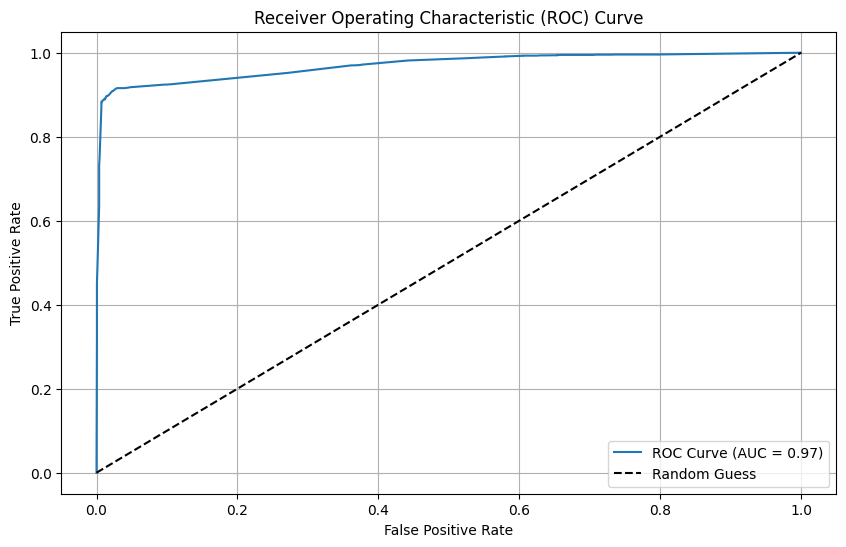

True Positives: 3137
False Positives: 81
True Negatives: 3376
False Negatives: 315


In [25]:
# Required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt
from fcmeans import FCM

# Step 1: Load dataset
dataset = pd.read_csv("balanced_dataset.csv")  # Replace with your file path
features = dataset.drop(columns=['target'])
target = dataset['target']

# Step 2: Normalize numerical columns
numeric_columns = ['stars', 'useful', 'funny']  # Adjust as needed
scaler = StandardScaler()
features_scaled = features.copy()
features_scaled[numeric_columns] = scaler.fit_transform(features[numeric_columns])

# Step 3: Fuzzy C-Means Clustering
# Use only numeric columns for clustering
clustering_data = features_scaled[numeric_columns].to_numpy()

# Initialize Fuzzy C-Means
fcm = FCM(n_clusters=3, m=2)  # Adjust clusters and fuzzifier as needed
fcm.fit(clustering_data)

# Membership scores for each cluster
membership_scores = fcm.u
features_scaled[['cluster1', 'cluster2', 'cluster3']] = membership_scores

# Step 4: Train-Test Split
X = features_scaled.drop(columns=['user_id', 'review_id', 'text', 'date'])
y = (target == 'genuine').astype(int)  # Encode target for binary classification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Train Classifier
clf = RandomForestClassifier(random_state=42, n_estimators=100)
clf.fit(X_train, y_train)

# Step 6: Predictions and Metrics
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print Results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# True Positives, False Positives, True Negatives, False Negatives
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"True Negatives: {TN}")
print(f"False Negatives: {FN}")

Accuracy: 0.69
Precision: 0.71
Recall: 0.63
F1 Score: 0.67

Confusion Matrix:
[[1703  589]
 [ 846 1468]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.74      0.70      2292
           1       0.71      0.63      0.67      2314

    accuracy                           0.69      4606
   macro avg       0.69      0.69      0.69      4606
weighted avg       0.69      0.69      0.69      4606



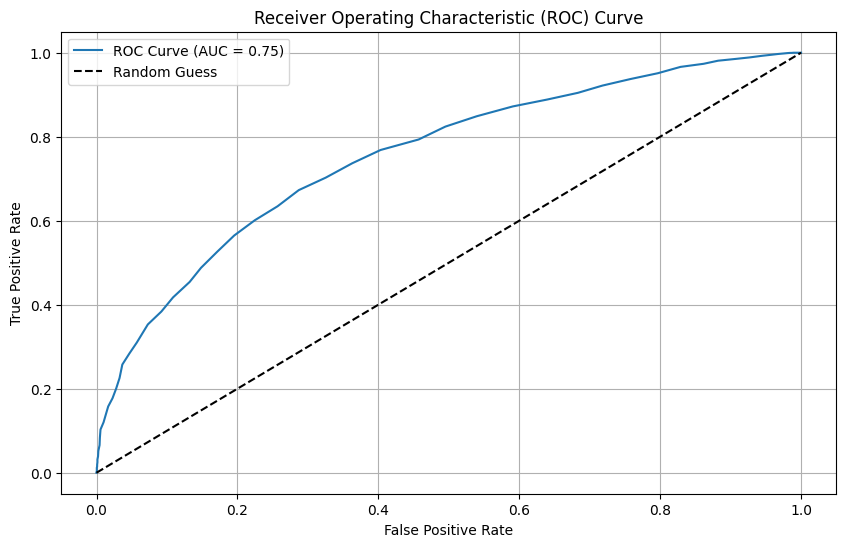

True Positives: 1468
False Positives: 589
True Negatives: 1703
False Negatives: 846


In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt
from fcmeans import FCM
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack, csr_matrix

# Step 1: Load dataset
dataset = pd.read_csv("processed_balanced_dataset.csv")  # Replace with your file path
features = dataset.drop(columns=['target'])
target = dataset['target']

# Step 2: Text Vectorization (TF-IDF) with sparse matrix
vectorizer = TfidfVectorizer(max_features=1000)  # Reduce number of features to 1000
text_features = vectorizer.fit_transform(features['processed_text'])

# Step 3: Dimensionality Reduction (optional)
svd = TruncatedSVD(n_components=500)  # Reduce to 500 components
text_features_reduced = svd.fit_transform(text_features)

# Step 4: Normalize numerical columns
numeric_columns = ['useful', 'funny']
scaler = StandardScaler()
features_scaled = features.copy()
features_scaled[numeric_columns] = scaler.fit_transform(features[numeric_columns])

# Convert numeric features to sparse format
numeric_sparse = csr_matrix(features_scaled[numeric_columns].values)

# Step 5: Combine text features and normalized numerical features
X = hstack([numeric_sparse, text_features_reduced])

# Step 6: Fuzzy C-Means Clustering
# Use only numeric columns for clustering
clustering_data = features_scaled[numeric_columns].to_numpy()

# Initialize Fuzzy C-Means
fcm = FCM(n_clusters=2, m=2)  # Adjust clusters and fuzzifier as needed
fcm.fit(clustering_data)

# Membership scores for each cluster
membership_scores = fcm.u
features_scaled[['cluster1', 'cluster2']] = membership_scores

# Step 7: Train-Test Split
y = (target == 'genuine').astype(int)  # Encode target for binary classification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Train Classifier
clf = RandomForestClassifier(random_state=42, n_estimators=100)
clf.fit(X_train, y_train)

# Step 9: Predictions and Metrics
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print Results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# True Positives, False Positives, True Negatives, False Negatives
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"True Negatives: {TN}")
print(f"False Negatives: {FN}")
